# Predicting future energy usage from multiple dependent time series

## Part 1: Load and examine the data

In [1]:
data_bucket = '' #we should use SageMaker default s3 bucket
subfolder = 'ch06'

In [ ]:
%matplotlib inline

from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import pandas as pd                               
import boto3
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

role = sagemaker.get_execution_role()
sess = sagemaker.session.Session()
data_bucket = sess.default_bucket()

print(f'SageMaker exectuion role: {role},  default s3 bucket: {data_bucket}')

In [3]:
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"

df = pd.read_csv(f'./meter_data.csv', index_col=0)
df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01 00:00:00,13.30,13.3,11.68,13.02,0.0,102.9,11.4,21.8,9.7,11.9,...,22.20,0.0,0.0,0,23.30,36.74,48.48,68.70,32.13,19.39
2017-11-01 00:30:00,11.75,11.9,12.63,13.36,0.0,122.1,11.3,17.7,9.0,12.4,...,21.68,0.0,0.0,0,22.14,36.44,50.18,69.09,29.02,19.54
2017-11-01 01:00:00,12.58,11.4,11.86,13.04,0.0,110.3,10.9,17.5,9.1,12.0,...,21.56,0.0,0.0,0,21.88,35.93,49.44,67.52,26.65,20.10
2017-11-01 01:30:00,12.50,10.8,11.53,11.83,0.0,83.6,11.2,16.5,12.4,11.5,...,21.28,0.0,0.0,0,22.69,45.25,49.57,68.48,25.28,19.46
2017-11-01 02:00:00,12.98,12.0,11.57,12.25,0.0,91.4,10.9,16.3,12.4,11.3,...,40.48,0.0,0.0,0,22.75,62.94,48.58,75.30,23.65,19.18


In [4]:
print(f'Number of rows in dataset: {df.shape[0]}')
print(f'Number of columns in dataset: {df.shape[1]}')

Number of rows in dataset: 19632
Number of columns in dataset: 48


## Part 2 : Get the data in the right shape

In [5]:
df.index = pd.to_datetime(df.index)
daily_df = df.resample('D').sum()
daily_df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,0.0,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,0.0,0.0,0,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,0.0,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,0.0,0.0,0,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,0.0,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,0.0,0.0,0,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,0.0,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,0.0,0.0,0,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,0.0,5221.5,929.4,1068.0,767.7,785.8,...,318.24,0.0,0.0,0,867.91,1849.85,2124.23,2320.60,726.15,554.00


In [6]:
print(daily_df.shape)
print(f'Time series starts at {daily_df.index[0]} and ends at {daily_df.index[-1]}')

(409, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2018-12-14 00:00:00


In [7]:
daily_df = daily_df.fillna(daily_df.shift(7))
daily_df

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,0.0,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,0.0,0.0,0,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,0.0,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,0.0,0.0,0,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,0.0,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,0.0,0.0,0,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,0.0,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,0.0,0.0,0,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,0.0,5221.5,929.4,1068.0,767.7,785.8,...,318.24,0.0,0.0,0,867.91,1849.85,2124.23,2320.60,726.15,554.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-10,1212.53,1070.1,1022.02,1239.53,1137.5,7216.9,574.0,677.3,1147.9,543.6,...,856.86,82760.0,71598.8,189,1865.03,3046.84,2497.72,2277.67,2724.62,852.67
2018-12-11,1318.45,1169.4,1119.27,1283.12,1254.8,8242.2,588.8,799.3,1215.9,624.4,...,957.00,81950.0,61727.4,298,1799.40,3005.03,2529.41,2247.49,2978.10,946.53
2018-12-12,1401.15,1232.6,1148.00,1378.76,1323.0,8792.0,730.3,959.6,1259.0,774.0,...,921.79,81380.0,72383.1,260,1713.26,2906.75,2435.32,0.00,3342.16,847.77
2018-12-13,1217.92,1058.8,1030.33,1258.77,1022.0,7400.2,668.1,720.8,1018.5,620.3,...,994.97,81770.0,67201.9,278,1788.17,3085.25,2617.42,2530.96,3143.55,997.05


Number of time series: 48


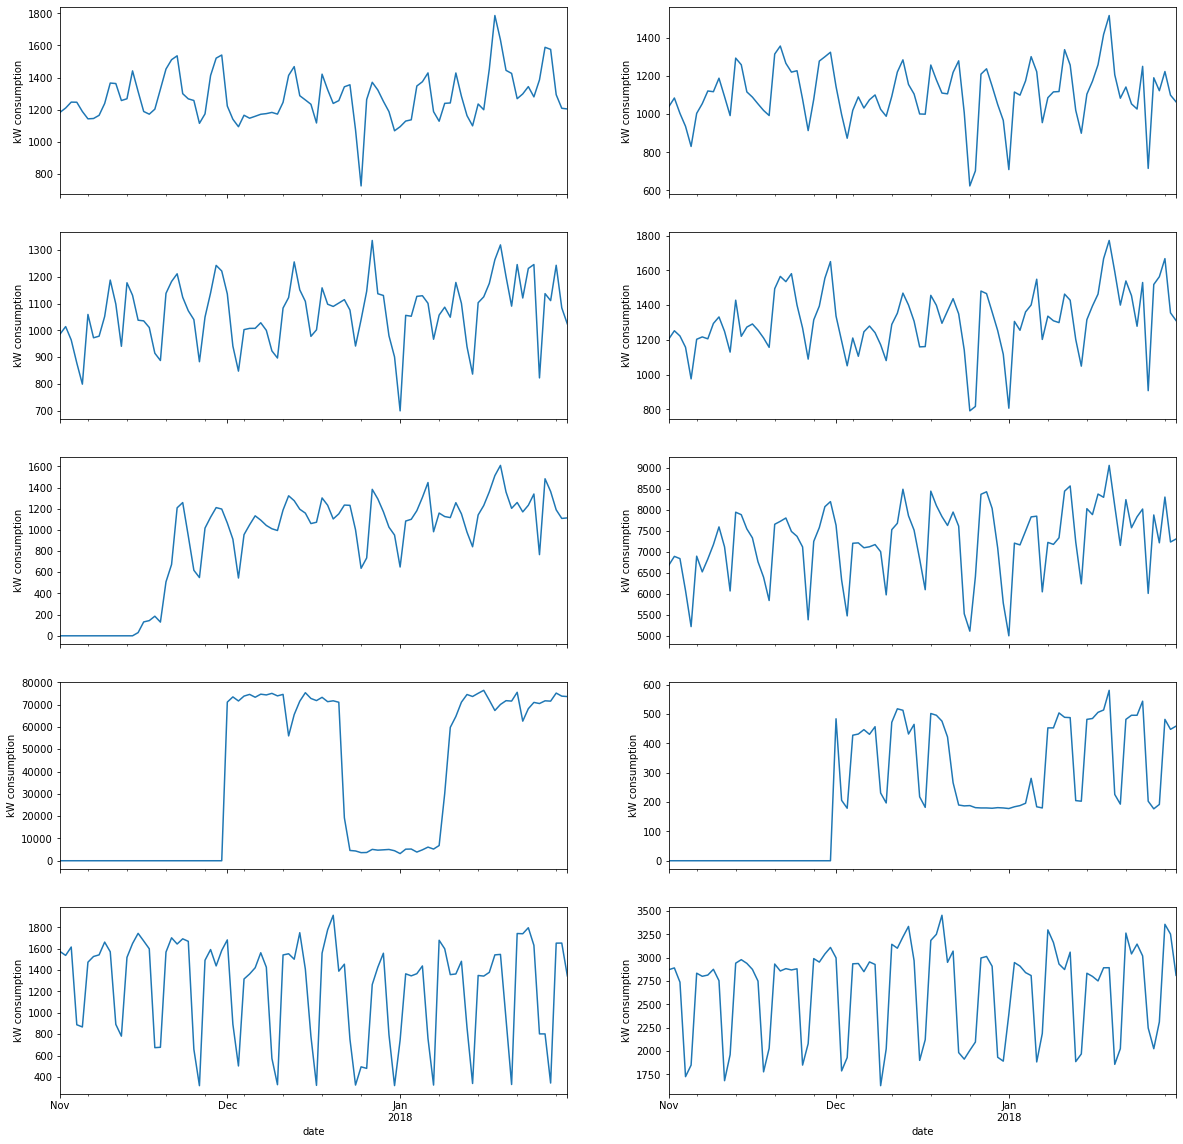

In [8]:
print('Number of time series:',daily_df.shape[1])
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
indices = [0,1,2,3,4,5,40,41,42,43]
for i in indices:
    plot_num = indices.index(i)
    daily_df[daily_df.columns[i]].loc["2017-11-01":"2018-01-31"].plot(ax=axx[plot_num])
    axx[plot_num].set_xlabel("date")    
    axx[plot_num].set_ylabel("kW consumption")

Visually there are some noticeable correlations which DeepAR will likely recognise and use!

## Part 3: Create Train and Test Datasets

In [9]:
daily_power_consumption_per_site = []
for column in daily_df.columns:
    site_consumption = np.trim_zeros(daily_df[column], trim='f')
    site_consumption = site_consumption.fillna(0)
    daily_power_consumption_per_site.append(site_consumption)
    
print(f'Time series covers {len(daily_power_consumption_per_site[0])} days.')
print(f'Time series starts at {daily_power_consumption_per_site[0].index[0]}')
print(f'Time series ends at {daily_power_consumption_per_site[0].index[-1]}') 

Time series covers 409 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2018-12-14 00:00:00


In [10]:
from datetime import timedelta

freq = 'D'
prediction_length = 30

start_date = pd.Timestamp("2017-11-01 00:00:00", freq=freq)
end_training = start_date + timedelta(days=364)
end_testing =end_training + timedelta(days=prediction_length)

print(f'Start : {start_date} , End training: {end_training}, End testing: {end_testing}')

Start : 2017-11-01 00:00:00 , End training: 2018-10-31 00:00:00, End testing: 2018-11-30 00:00:00


In [11]:
training_data = [
    {
        "start": str(start_date),
        "target": ts[start_date:end_training].tolist()
    }
    for ts in daily_power_consumption_per_site
]


test_data = [
    {
        "start": str(start_date),
        "target": ts[start_date:end_testing].tolist()
    }
    for ts in daily_power_consumption_per_site
]



In [ ]:
from sagemaker.s3 import S3Uploader

def write_dicts_to_s3(path, data):
    basename=os.path.basename(path)
    if os.path.exists(f'./{basename}') == False:
        print(f'Write file: {basename}')
        with open(f'./{basename}', 'wb') as f:
            for d in data:
                f.write(json.dumps(d).encode("utf-8"))
                f.write("\n".encode('utf-8'))
            f.close()
    else:
        print(f'{basename} already exits')
    file_path=S3Uploader.upload(f'./{basename}', os.path.dirname(path))

    print(f'update load {file_path}')
   
write_dicts_to_s3(f'{s3_data_path}/train/train.json', training_data)
write_dicts_to_s3(f'{s3_data_path}/test/test.json', test_data)


## Part 4: Train the Model

In [16]:
%%time

s3_output_path = f's3://{data_bucket}/{subfolder}/output'
sess = sagemaker.Session()
image_name = sagemaker.image_uris.retrieve(
                region=boto3.Session().region_name,
                framework='forecasting-deepar',
                version='1')


estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_uri=image_name,
    role=role,
    instance_count=1,
    instance_type='ml.c5.2xlarge', # $0.476 per hour as of Jan 2019.
    base_job_name='ch6-energy-usage',
    output_path=s3_output_path
)

estimator.set_hyperparameters(
    time_freq=freq,
    epochs="400",
    early_stopping_patience="40",
    mini_batch_size="64",
    learning_rate="5E-4",
    context_length="90",
    prediction_length=str(prediction_length)
)


data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}
estimator.fit(inputs=data_channels, wait=True)

2022-02-11 11:48:18 Starting - Starting the training job...
2022-02-11 11:48:21 Starting - Launching requested ML instancesProfilerReport-1644580098: InProgress
.........
2022-02-11 11:50:18 Starting - Preparing the instances for training...
2022-02-11 11:50:46 Downloading - Downloading input data...
2022-02-11 11:51:18 Training - Downloading the training image...
2022-02-11 11:51:46 Training - Training image download completed. Training in progress..Arguments: train
[02/11/2022 11:51:49 INFO 139709780391552] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_laye

[02/11/2022 11:51:55 INFO 139709780391552] Epoch[2] Batch[10] avg_epoch_loss=7.099544
[02/11/2022 11:51:55 INFO 139709780391552] #quality_metric: host=algo-1, epoch=2, batch=10 train loss <loss>=7.284661102294922
[02/11/2022 11:51:55 INFO 139709780391552] Epoch[2] Batch [10]#011Speed: 485.29 samples/sec#011loss=7.284661
[02/11/2022 11:51:55 INFO 139709780391552] processed a total of 674 examples
#metrics {"StartTime": 1644580313.9206274, "EndTime": 1644580315.5512142, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1630.526065826416, "count": 1, "min": 1630.526065826416, "max": 1630.526065826416}}}
[02/11/2022 11:51:55 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=413.33971057924504 records/second
[02/11/2022 11:51:55 INFO 139709780391552] #progress_metric: host=algo-1, completed 0.75 % of epochs
[02/11/2022 11:51:55 INFO 139709780391552] #quality_metric: host=algo-1, epoch=2, train loss 

[02/11/2022 11:52:05 INFO 139709780391552] Epoch[9] Batch[0] avg_epoch_loss=6.804000
[02/11/2022 11:52:05 INFO 139709780391552] #quality_metric: host=algo-1, epoch=9, batch=0 train loss <loss>=6.804000377655029
[02/11/2022 11:52:06 INFO 139709780391552] Epoch[9] Batch[5] avg_epoch_loss=6.812269
[02/11/2022 11:52:06 INFO 139709780391552] #quality_metric: host=algo-1, epoch=9, batch=5 train loss <loss>=6.812268654505412
[02/11/2022 11:52:06 INFO 139709780391552] Epoch[9] Batch [5]#011Speed: 392.98 samples/sec#011loss=6.812269
[02/11/2022 11:52:07 INFO 139709780391552] processed a total of 630 examples
#metrics {"StartTime": 1644580325.3583772, "EndTime": 1644580327.1145065, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1755.8097839355469, "count": 1, "min": 1755.8097839355469, "max": 1755.8097839355469}}}
[02/11/2022 11:52:07 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=358.7871677933707

[02/11/2022 11:52:16 INFO 139709780391552] Epoch[15] Batch[5] avg_epoch_loss=6.481441
[02/11/2022 11:52:16 INFO 139709780391552] #quality_metric: host=algo-1, epoch=15, batch=5 train loss <loss>=6.481440941492717
[02/11/2022 11:52:16 INFO 139709780391552] Epoch[15] Batch [5]#011Speed: 471.18 samples/sec#011loss=6.481441
[02/11/2022 11:52:16 INFO 139709780391552] Epoch[15] Batch[10] avg_epoch_loss=6.503352
[02/11/2022 11:52:16 INFO 139709780391552] #quality_metric: host=algo-1, epoch=15, batch=10 train loss <loss>=6.52964506149292
[02/11/2022 11:52:16 INFO 139709780391552] Epoch[15] Batch [10]#011Speed: 484.60 samples/sec#011loss=6.529645
[02/11/2022 11:52:16 INFO 139709780391552] processed a total of 642 examples
#metrics {"StartTime": 1644580335.0611224, "EndTime": 1644580336.6832962, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1622.1120357513428, "count": 1, "min": 1622.1120357513428, "max": 1622.11203575134

[02/11/2022 11:52:26 INFO 139709780391552] Epoch[21] Batch[10] avg_epoch_loss=6.349434
[02/11/2022 11:52:26 INFO 139709780391552] #quality_metric: host=algo-1, epoch=21, batch=10 train loss <loss>=6.490902614593506
[02/11/2022 11:52:26 INFO 139709780391552] Epoch[21] Batch [10]#011Speed: 476.58 samples/sec#011loss=6.490903
[02/11/2022 11:52:26 INFO 139709780391552] processed a total of 649 examples
#metrics {"StartTime": 1644580344.5189507, "EndTime": 1644580346.149601, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1630.3133964538574, "count": 1, "min": 1630.3133964538574, "max": 1630.3133964538574}}}
[02/11/2022 11:52:26 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=398.0587542842336 records/second
[02/11/2022 11:52:26 INFO 139709780391552] #progress_metric: host=algo-1, completed 5.5 % of epochs
[02/11/2022 11:52:26 INFO 139709780391552] #quality_metric: host=algo-1, epoch=21, train l

[02/11/2022 11:52:35 INFO 139709780391552] Epoch[28] Batch[0] avg_epoch_loss=6.617162
[02/11/2022 11:52:35 INFO 139709780391552] #quality_metric: host=algo-1, epoch=28, batch=0 train loss <loss>=6.617162227630615
[02/11/2022 11:52:36 INFO 139709780391552] Epoch[28] Batch[5] avg_epoch_loss=6.407050
[02/11/2022 11:52:36 INFO 139709780391552] #quality_metric: host=algo-1, epoch=28, batch=5 train loss <loss>=6.407049655914307
[02/11/2022 11:52:36 INFO 139709780391552] Epoch[28] Batch [5]#011Speed: 471.09 samples/sec#011loss=6.407050
[02/11/2022 11:52:36 INFO 139709780391552] processed a total of 636 examples
#metrics {"StartTime": 1644580355.387822, "EndTime": 1644580356.8855307, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1497.6444244384766, "count": 1, "min": 1497.6444244384766, "max": 1497.6444244384766}}}
[02/11/2022 11:52:36 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=424.637416165

[02/11/2022 11:52:45 INFO 139709780391552] Epoch[34] Batch[5] avg_epoch_loss=6.330931
[02/11/2022 11:52:45 INFO 139709780391552] #quality_metric: host=algo-1, epoch=34, batch=5 train loss <loss>=6.330931345621745
[02/11/2022 11:52:45 INFO 139709780391552] Epoch[34] Batch [5]#011Speed: 487.33 samples/sec#011loss=6.330931
[02/11/2022 11:52:46 INFO 139709780391552] processed a total of 620 examples
#metrics {"StartTime": 1644580364.7912447, "EndTime": 1644580366.2913337, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1499.788522720337, "count": 1, "min": 1499.788522720337, "max": 1499.788522720337}}}
[02/11/2022 11:52:46 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=413.3600739717653 records/second
[02/11/2022 11:52:46 INFO 139709780391552] #progress_metric: host=algo-1, completed 8.75 % of epochs
[02/11/2022 11:52:46 INFO 139709780391552] #quality_metric: host=algo-1, epoch=34, train loss 

[02/11/2022 11:52:55 INFO 139709780391552] Epoch[40] Batch[10] avg_epoch_loss=6.394623
[02/11/2022 11:52:55 INFO 139709780391552] #quality_metric: host=algo-1, epoch=40, batch=10 train loss <loss>=6.439581108093262
[02/11/2022 11:52:55 INFO 139709780391552] Epoch[40] Batch [10]#011Speed: 482.64 samples/sec#011loss=6.439581
[02/11/2022 11:52:55 INFO 139709780391552] processed a total of 665 examples
#metrics {"StartTime": 1644580374.0957568, "EndTime": 1644580375.731687, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1635.6334686279297, "count": 1, "min": 1635.6334686279297, "max": 1635.6334686279297}}}
[02/11/2022 11:52:55 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=406.5476093131238 records/second
[02/11/2022 11:52:55 INFO 139709780391552] #progress_metric: host=algo-1, completed 10.25 % of epochs
[02/11/2022 11:52:55 INFO 139709780391552] #quality_metric: host=algo-1, epoch=40, train

[02/11/2022 11:53:05 INFO 139709780391552] Epoch[46] Batch[10] avg_epoch_loss=6.030302
[02/11/2022 11:53:05 INFO 139709780391552] #quality_metric: host=algo-1, epoch=46, batch=10 train loss <loss>=5.796502876281738
[02/11/2022 11:53:05 INFO 139709780391552] Epoch[46] Batch [10]#011Speed: 454.50 samples/sec#011loss=5.796503
[02/11/2022 11:53:05 INFO 139709780391552] processed a total of 661 examples
#metrics {"StartTime": 1644580383.8358395, "EndTime": 1644580385.572661, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1736.5224361419678, "count": 1, "min": 1736.5224361419678, "max": 1736.5224361419678}}}
[02/11/2022 11:53:05 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=380.6270552627164 records/second
[02/11/2022 11:53:05 INFO 139709780391552] #progress_metric: host=algo-1, completed 11.75 % of epochs
[02/11/2022 11:53:05 INFO 139709780391552] #quality_metric: host=algo-1, epoch=46, train

[02/11/2022 11:53:20 INFO 139709780391552] Epoch[56] Batch[5] avg_epoch_loss=6.366624
[02/11/2022 11:53:20 INFO 139709780391552] #quality_metric: host=algo-1, epoch=56, batch=5 train loss <loss>=6.366623560587565
[02/11/2022 11:53:20 INFO 139709780391552] Epoch[56] Batch [5]#011Speed: 481.25 samples/sec#011loss=6.366624
[02/11/2022 11:53:21 INFO 139709780391552] Epoch[56] Batch[10] avg_epoch_loss=6.287877
[02/11/2022 11:53:21 INFO 139709780391552] #quality_metric: host=algo-1, epoch=56, batch=10 train loss <loss>=6.193381690979004
[02/11/2022 11:53:21 INFO 139709780391552] Epoch[56] Batch [10]#011Speed: 480.91 samples/sec#011loss=6.193382
[02/11/2022 11:53:21 INFO 139709780391552] processed a total of 650 examples
#metrics {"StartTime": 1644580400.0075083, "EndTime": 1644580401.621443, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1613.530158996582, "count": 1, "min": 1613.530158996582, "max": 1613.530158996582}

[02/11/2022 11:53:31 INFO 139709780391552] processed a total of 631 examples
#metrics {"StartTime": 1644580409.531988, "EndTime": 1644580411.0136144, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1481.2612533569336, "count": 1, "min": 1481.2612533569336, "max": 1481.2612533569336}}}
[02/11/2022 11:53:31 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=425.95479893371515 records/second
[02/11/2022 11:53:31 INFO 139709780391552] #progress_metric: host=algo-1, completed 15.75 % of epochs
[02/11/2022 11:53:31 INFO 139709780391552] #quality_metric: host=algo-1, epoch=62, train loss <loss>=6.249077081680298
[02/11/2022 11:53:31 INFO 139709780391552] loss did not improve
[02/11/2022 11:53:31 INFO 139709780391552] Epoch[63] Batch[0] avg_epoch_loss=6.205459
[02/11/2022 11:53:31 INFO 139709780391552] #quality_metric: host=algo-1, epoch=63, batch=0 train loss <loss>=6.205458641052246
[02/11/2022 11:5

[02/11/2022 11:53:40 INFO 139709780391552] Epoch[68] Batch[10] avg_epoch_loss=6.230592
[02/11/2022 11:53:40 INFO 139709780391552] #quality_metric: host=algo-1, epoch=68, batch=10 train loss <loss>=6.179881954193116
[02/11/2022 11:53:40 INFO 139709780391552] Epoch[68] Batch [10]#011Speed: 479.49 samples/sec#011loss=6.179882
[02/11/2022 11:53:40 INFO 139709780391552] processed a total of 678 examples
#metrics {"StartTime": 1644580419.005917, "EndTime": 1644580420.660972, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1654.719591140747, "count": 1, "min": 1654.719591140747, "max": 1654.719591140747}}}
[02/11/2022 11:53:40 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=409.71484044863007 records/second
[02/11/2022 11:53:40 INFO 139709780391552] #progress_metric: host=algo-1, completed 17.25 % of epochs
[02/11/2022 11:53:40 INFO 139709780391552] #quality_metric: host=algo-1, epoch=68, train lo

[02/11/2022 11:53:50 INFO 139709780391552] Epoch[75] Batch[5] avg_epoch_loss=6.417533
[02/11/2022 11:53:50 INFO 139709780391552] #quality_metric: host=algo-1, epoch=75, batch=5 train loss <loss>=6.417532841364543
[02/11/2022 11:53:50 INFO 139709780391552] Epoch[75] Batch [5]#011Speed: 485.26 samples/sec#011loss=6.417533
[02/11/2022 11:53:51 INFO 139709780391552] processed a total of 626 examples
#metrics {"StartTime": 1644580429.776989, "EndTime": 1644580431.2510548, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1473.7708568572998, "count": 1, "min": 1473.7708568572998, "max": 1473.7708568572998}}}
[02/11/2022 11:53:51 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=424.7311258689517 records/second
[02/11/2022 11:53:51 INFO 139709780391552] #progress_metric: host=algo-1, completed 19.0 % of epochs
[02/11/2022 11:53:51 INFO 139709780391552] #quality_metric: host=algo-1, epoch=75, train los

[02/11/2022 11:54:00 INFO 139709780391552] processed a total of 618 examples
#metrics {"StartTime": 1644580439.1022112, "EndTime": 1644580440.5863376, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1483.7126731872559, "count": 1, "min": 1483.7126731872559, "max": 1483.7126731872559}}}
[02/11/2022 11:54:00 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=416.4931795719604 records/second
[02/11/2022 11:54:00 INFO 139709780391552] #progress_metric: host=algo-1, completed 20.5 % of epochs
[02/11/2022 11:54:00 INFO 139709780391552] #quality_metric: host=algo-1, epoch=81, train loss <loss>=6.041201400756836
[02/11/2022 11:54:00 INFO 139709780391552] loss did not improve
[02/11/2022 11:54:00 INFO 139709780391552] Epoch[82] Batch[0] avg_epoch_loss=6.489467
[02/11/2022 11:54:00 INFO 139709780391552] #quality_metric: host=algo-1, epoch=82, batch=0 train loss <loss>=6.489466667175293
[02/11/2022 11:54

[02/11/2022 11:54:10 INFO 139709780391552] processed a total of 633 examples
#metrics {"StartTime": 1644580449.1714416, "EndTime": 1644580450.6578593, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1486.0365390777588, "count": 1, "min": 1486.0365390777588, "max": 1486.0365390777588}}}
[02/11/2022 11:54:10 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=425.93687169166276 records/second
[02/11/2022 11:54:10 INFO 139709780391552] #progress_metric: host=algo-1, completed 22.0 % of epochs
[02/11/2022 11:54:10 INFO 139709780391552] #quality_metric: host=algo-1, epoch=87, train loss <loss>=6.258445501327515
[02/11/2022 11:54:10 INFO 139709780391552] loss did not improve
[02/11/2022 11:54:10 INFO 139709780391552] Epoch[88] Batch[0] avg_epoch_loss=6.032870
[02/11/2022 11:54:10 INFO 139709780391552] #quality_metric: host=algo-1, epoch=88, batch=0 train loss <loss>=6.032869815826416
[02/11/2022 11:5

[02/11/2022 11:54:20 INFO 139709780391552] Epoch[94] Batch[5] avg_epoch_loss=6.158021
[02/11/2022 11:54:20 INFO 139709780391552] #quality_metric: host=algo-1, epoch=94, batch=5 train loss <loss>=6.158020734786987
[02/11/2022 11:54:20 INFO 139709780391552] Epoch[94] Batch [5]#011Speed: 465.23 samples/sec#011loss=6.158021
[02/11/2022 11:54:21 INFO 139709780391552] Epoch[94] Batch[10] avg_epoch_loss=6.199859
[02/11/2022 11:54:21 INFO 139709780391552] #quality_metric: host=algo-1, epoch=94, batch=10 train loss <loss>=6.2500652313232425
[02/11/2022 11:54:21 INFO 139709780391552] Epoch[94] Batch [10]#011Speed: 476.48 samples/sec#011loss=6.250065
[02/11/2022 11:54:21 INFO 139709780391552] processed a total of 690 examples
#metrics {"StartTime": 1644580459.6917768, "EndTime": 1644580461.3515954, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1659.4769954681396, "count": 1, "min": 1659.4769954681396, "max": 1659.476995468

[02/11/2022 11:54:31 INFO 139709780391552] Epoch[100] Batch[10] avg_epoch_loss=6.498426
[02/11/2022 11:54:31 INFO 139709780391552] #quality_metric: host=algo-1, epoch=100, batch=10 train loss <loss>=6.7478837966918945
[02/11/2022 11:54:31 INFO 139709780391552] Epoch[100] Batch [10]#011Speed: 486.47 samples/sec#011loss=6.747884
[02/11/2022 11:54:31 INFO 139709780391552] processed a total of 643 examples
#metrics {"StartTime": 1644580469.580685, "EndTime": 1644580471.2213106, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1640.2332782745361, "count": 1, "min": 1640.2332782745361, "max": 1640.2332782745361}}}
[02/11/2022 11:54:31 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=391.9921105580007 records/second
[02/11/2022 11:54:31 INFO 139709780391552] #progress_metric: host=algo-1, completed 25.25 % of epochs
[02/11/2022 11:54:31 INFO 139709780391552] #quality_metric: host=algo-1, epoch=100, 

[02/11/2022 11:54:40 INFO 139709780391552] Epoch[107] Batch[0] avg_epoch_loss=6.056794
[02/11/2022 11:54:40 INFO 139709780391552] #quality_metric: host=algo-1, epoch=107, batch=0 train loss <loss>=6.056793689727783
[02/11/2022 11:54:41 INFO 139709780391552] Epoch[107] Batch[5] avg_epoch_loss=6.207147
[02/11/2022 11:54:41 INFO 139709780391552] #quality_metric: host=algo-1, epoch=107, batch=5 train loss <loss>=6.207146565119426
[02/11/2022 11:54:41 INFO 139709780391552] Epoch[107] Batch [5]#011Speed: 484.92 samples/sec#011loss=6.207147
[02/11/2022 11:54:41 INFO 139709780391552] processed a total of 606 examples
#metrics {"StartTime": 1644580480.3413634, "EndTime": 1644580481.833543, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1491.8396472930908, "count": 1, "min": 1491.8396472930908, "max": 1491.8396472930908}}}
[02/11/2022 11:54:41 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=406.1756

[02/11/2022 11:54:50 INFO 139709780391552] Epoch[113] Batch[5] avg_epoch_loss=6.149740
[02/11/2022 11:54:50 INFO 139709780391552] #quality_metric: host=algo-1, epoch=113, batch=5 train loss <loss>=6.149739901224772
[02/11/2022 11:54:50 INFO 139709780391552] Epoch[113] Batch [5]#011Speed: 473.53 samples/sec#011loss=6.149740
[02/11/2022 11:54:51 INFO 139709780391552] processed a total of 605 examples
#metrics {"StartTime": 1644580489.7631645, "EndTime": 1644580491.2517538, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1488.2147312164307, "count": 1, "min": 1488.2147312164307, "max": 1488.2147312164307}}}
[02/11/2022 11:54:51 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=406.501306783822 records/second
[02/11/2022 11:54:51 INFO 139709780391552] #progress_metric: host=algo-1, completed 28.5 % of epochs
[02/11/2022 11:54:51 INFO 139709780391552] #quality_metric: host=algo-1, epoch=113, train

[02/11/2022 11:55:00 INFO 139709780391552] Epoch[119] Batch[10] avg_epoch_loss=6.197096
[02/11/2022 11:55:00 INFO 139709780391552] #quality_metric: host=algo-1, epoch=119, batch=10 train loss <loss>=6.26626443862915
[02/11/2022 11:55:00 INFO 139709780391552] Epoch[119] Batch [10]#011Speed: 462.81 samples/sec#011loss=6.266264
[02/11/2022 11:55:00 INFO 139709780391552] processed a total of 671 examples
#metrics {"StartTime": 1644580499.0540938, "EndTime": 1644580500.6836736, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1629.1399002075195, "count": 1, "min": 1629.1399002075195, "max": 1629.1399002075195}}}
[02/11/2022 11:55:00 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=411.8502079242274 records/second
[02/11/2022 11:55:00 INFO 139709780391552] #progress_metric: host=algo-1, completed 30.0 % of epochs
[02/11/2022 11:55:00 INFO 139709780391552] #quality_metric: host=algo-1, epoch=119, tr

[02/11/2022 11:55:10 INFO 139709780391552] Epoch[126] Batch[0] avg_epoch_loss=6.342101
[02/11/2022 11:55:10 INFO 139709780391552] #quality_metric: host=algo-1, epoch=126, batch=0 train loss <loss>=6.342100620269775
[02/11/2022 11:55:11 INFO 139709780391552] Epoch[126] Batch[5] avg_epoch_loss=6.291421
[02/11/2022 11:55:11 INFO 139709780391552] #quality_metric: host=algo-1, epoch=126, batch=5 train loss <loss>=6.291421016057332
[02/11/2022 11:55:11 INFO 139709780391552] Epoch[126] Batch [5]#011Speed: 475.29 samples/sec#011loss=6.291421
[02/11/2022 11:55:12 INFO 139709780391552] processed a total of 593 examples
#metrics {"StartTime": 1644580510.541211, "EndTime": 1644580512.0383732, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1496.7491626739502, "count": 1, "min": 1496.7491626739502, "max": 1496.7491626739502}}}
[02/11/2022 11:55:12 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=396.1662

[02/11/2022 11:55:26 INFO 139709780391552] Epoch[135] Batch[10] avg_epoch_loss=5.983410
[02/11/2022 11:55:26 INFO 139709780391552] #quality_metric: host=algo-1, epoch=135, batch=10 train loss <loss>=5.800697708129883
[02/11/2022 11:55:26 INFO 139709780391552] Epoch[135] Batch [10]#011Speed: 454.86 samples/sec#011loss=5.800698
[02/11/2022 11:55:26 INFO 139709780391552] processed a total of 644 examples
#metrics {"StartTime": 1644580524.4869587, "EndTime": 1644580526.1543639, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1667.0074462890625, "count": 1, "min": 1667.0074462890625, "max": 1667.0074462890625}}}
[02/11/2022 11:55:26 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=386.2998493060743 records/second
[02/11/2022 11:55:26 INFO 139709780391552] #progress_metric: host=algo-1, completed 34.0 % of epochs
[02/11/2022 11:55:26 INFO 139709780391552] #quality_metric: host=algo-1, epoch=135, t

[02/11/2022 11:55:35 INFO 139709780391552] Epoch[142] Batch[0] avg_epoch_loss=6.448269
[02/11/2022 11:55:35 INFO 139709780391552] #quality_metric: host=algo-1, epoch=142, batch=0 train loss <loss>=6.448269367218018
[02/11/2022 11:55:36 INFO 139709780391552] Epoch[142] Batch[5] avg_epoch_loss=6.079839
[02/11/2022 11:55:36 INFO 139709780391552] #quality_metric: host=algo-1, epoch=142, batch=5 train loss <loss>=6.079838832219441
[02/11/2022 11:55:36 INFO 139709780391552] Epoch[142] Batch [5]#011Speed: 480.43 samples/sec#011loss=6.079839
[02/11/2022 11:55:37 INFO 139709780391552] Epoch[142] Batch[10] avg_epoch_loss=6.044333
[02/11/2022 11:55:37 INFO 139709780391552] #quality_metric: host=algo-1, epoch=142, batch=10 train loss <loss>=6.00172643661499
[02/11/2022 11:55:37 INFO 139709780391552] Epoch[142] Batch [10]#011Speed: 470.44 samples/sec#011loss=6.001726
[02/11/2022 11:55:37 INFO 139709780391552] processed a total of 646 examples
#metrics {"StartTime": 1644580535.5742905, "EndTime": 16

[02/11/2022 11:55:45 INFO 139709780391552] Epoch[148] Batch[5] avg_epoch_loss=6.058319
[02/11/2022 11:55:45 INFO 139709780391552] #quality_metric: host=algo-1, epoch=148, batch=5 train loss <loss>=6.058318932851155
[02/11/2022 11:55:45 INFO 139709780391552] Epoch[148] Batch [5]#011Speed: 483.31 samples/sec#011loss=6.058319
[02/11/2022 11:55:46 INFO 139709780391552] Epoch[148] Batch[10] avg_epoch_loss=6.227275
[02/11/2022 11:55:46 INFO 139709780391552] #quality_metric: host=algo-1, epoch=148, batch=10 train loss <loss>=6.43002290725708
[02/11/2022 11:55:46 INFO 139709780391552] Epoch[148] Batch [10]#011Speed: 481.25 samples/sec#011loss=6.430023
[02/11/2022 11:55:46 INFO 139709780391552] processed a total of 666 examples
#metrics {"StartTime": 1644580544.940358, "EndTime": 1644580546.5545125, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1613.804578781128, "count": 1, "min": 1613.804578781128, "max": 1613.80457878

[02/11/2022 11:55:55 INFO 139709780391552] Epoch[154] Batch[10] avg_epoch_loss=6.364483
[02/11/2022 11:55:55 INFO 139709780391552] #quality_metric: host=algo-1, epoch=154, batch=10 train loss <loss>=6.646856498718262
[02/11/2022 11:55:55 INFO 139709780391552] Epoch[154] Batch [10]#011Speed: 468.96 samples/sec#011loss=6.646856
[02/11/2022 11:55:55 INFO 139709780391552] processed a total of 671 examples
#metrics {"StartTime": 1644580554.258741, "EndTime": 1644580555.8852382, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1626.4331340789795, "count": 1, "min": 1626.4331340789795, "max": 1626.4331340789795}}}
[02/11/2022 11:55:55 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=412.5329837681131 records/second
[02/11/2022 11:55:55 INFO 139709780391552] #progress_metric: host=algo-1, completed 38.75 % of epochs
[02/11/2022 11:55:55 INFO 139709780391552] #quality_metric: host=algo-1, epoch=154, t

[02/11/2022 11:56:06 INFO 139709780391552] Epoch[161] Batch[5] avg_epoch_loss=6.048698
[02/11/2022 11:56:06 INFO 139709780391552] #quality_metric: host=algo-1, epoch=161, batch=5 train loss <loss>=6.048698345820109
[02/11/2022 11:56:06 INFO 139709780391552] Epoch[161] Batch [5]#011Speed: 399.61 samples/sec#011loss=6.048698
[02/11/2022 11:56:07 INFO 139709780391552] Epoch[161] Batch[10] avg_epoch_loss=6.084481
[02/11/2022 11:56:07 INFO 139709780391552] #quality_metric: host=algo-1, epoch=161, batch=10 train loss <loss>=6.127420139312744
[02/11/2022 11:56:07 INFO 139709780391552] Epoch[161] Batch [10]#011Speed: 401.39 samples/sec#011loss=6.127420
[02/11/2022 11:56:07 INFO 139709780391552] processed a total of 657 examples
#metrics {"StartTime": 1644580565.301442, "EndTime": 1644580567.1927874, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1891.0088539123535, "count": 1, "min": 1891.0088539123535, "max": 1891.00885

[02/11/2022 11:56:15 INFO 139709780391552] Epoch[167] Batch[5] avg_epoch_loss=6.207866
[02/11/2022 11:56:15 INFO 139709780391552] #quality_metric: host=algo-1, epoch=167, batch=5 train loss <loss>=6.207866430282593
[02/11/2022 11:56:15 INFO 139709780391552] Epoch[167] Batch [5]#011Speed: 490.57 samples/sec#011loss=6.207866
[02/11/2022 11:56:16 INFO 139709780391552] Epoch[167] Batch[10] avg_epoch_loss=6.090944
[02/11/2022 11:56:16 INFO 139709780391552] #quality_metric: host=algo-1, epoch=167, batch=10 train loss <loss>=5.950636100769043
[02/11/2022 11:56:16 INFO 139709780391552] Epoch[167] Batch [10]#011Speed: 486.19 samples/sec#011loss=5.950636
[02/11/2022 11:56:16 INFO 139709780391552] processed a total of 647 examples
#metrics {"StartTime": 1644580574.8777986, "EndTime": 1644580576.494048, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1615.870714187622, "count": 1, "min": 1615.870714187622, "max": 1615.8707141

[02/11/2022 11:56:26 INFO 139709780391552] Epoch[173] Batch[10] avg_epoch_loss=6.545533
[02/11/2022 11:56:26 INFO 139709780391552] #quality_metric: host=algo-1, epoch=173, batch=10 train loss <loss>=6.734725379943848
[02/11/2022 11:56:26 INFO 139709780391552] Epoch[173] Batch [10]#011Speed: 482.42 samples/sec#011loss=6.734725
[02/11/2022 11:56:26 INFO 139709780391552] processed a total of 660 examples
#metrics {"StartTime": 1644580584.4395661, "EndTime": 1644580586.0564709, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1616.593360900879, "count": 1, "min": 1616.593360900879, "max": 1616.593360900879}}}
[02/11/2022 11:56:26 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=408.24383842087076 records/second
[02/11/2022 11:56:26 INFO 139709780391552] #progress_metric: host=algo-1, completed 43.5 % of epochs
[02/11/2022 11:56:26 INFO 139709780391552] #quality_metric: host=algo-1, epoch=173, tra

[02/11/2022 11:56:35 INFO 139709780391552] Epoch[180] Batch[0] avg_epoch_loss=6.290322
[02/11/2022 11:56:35 INFO 139709780391552] #quality_metric: host=algo-1, epoch=180, batch=0 train loss <loss>=6.290322303771973
[02/11/2022 11:56:36 INFO 139709780391552] Epoch[180] Batch[5] avg_epoch_loss=6.191560
[02/11/2022 11:56:36 INFO 139709780391552] #quality_metric: host=algo-1, epoch=180, batch=5 train loss <loss>=6.19156010945638
[02/11/2022 11:56:36 INFO 139709780391552] Epoch[180] Batch [5]#011Speed: 482.76 samples/sec#011loss=6.191560
[02/11/2022 11:56:36 INFO 139709780391552] processed a total of 634 examples
#metrics {"StartTime": 1644580595.4637275, "EndTime": 1644580596.939076, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1474.9152660369873, "count": 1, "min": 1474.9152660369873, "max": 1474.9152660369873}}}
[02/11/2022 11:56:36 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=429.82817

[02/11/2022 11:56:46 INFO 139709780391552] Epoch[186] Batch[10] avg_epoch_loss=6.032115
[02/11/2022 11:56:46 INFO 139709780391552] #quality_metric: host=algo-1, epoch=186, batch=10 train loss <loss>=6.029817295074463
[02/11/2022 11:56:46 INFO 139709780391552] Epoch[186] Batch [10]#011Speed: 487.46 samples/sec#011loss=6.029817
[02/11/2022 11:56:46 INFO 139709780391552] processed a total of 642 examples
#metrics {"StartTime": 1644580604.491746, "EndTime": 1644580606.1119845, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1619.89426612854, "count": 1, "min": 1619.89426612854, "max": 1619.89426612854}}}
[02/11/2022 11:56:46 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=396.2991821741666 records/second
[02/11/2022 11:56:46 INFO 139709780391552] #progress_metric: host=algo-1, completed 46.75 % of epochs
[02/11/2022 11:56:46 INFO 139709780391552] #quality_metric: host=algo-1, epoch=186, train l

[02/11/2022 11:56:55 INFO 139709780391552] Epoch[192] Batch[10] avg_epoch_loss=6.114206
[02/11/2022 11:56:55 INFO 139709780391552] #quality_metric: host=algo-1, epoch=192, batch=10 train loss <loss>=6.190722179412842
[02/11/2022 11:56:55 INFO 139709780391552] Epoch[192] Batch [10]#011Speed: 470.00 samples/sec#011loss=6.190722
[02/11/2022 11:56:55 INFO 139709780391552] processed a total of 687 examples
#metrics {"StartTime": 1644580614.1268322, "EndTime": 1644580615.7622383, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1634.995937347412, "count": 1, "min": 1634.995937347412, "max": 1634.995937347412}}}
[02/11/2022 11:56:55 INFO 139709780391552] #throughput_metric: host=algo-1, train throughput=420.1608805760699 records/second
[02/11/2022 11:56:55 INFO 139709780391552] #progress_metric: host=algo-1, completed 48.25 % of epochs
[02/11/2022 11:56:55 INFO 139709780391552] #quality_metric: host=algo-1, epoch=192, tra

Training seconds: 384
Billable seconds: 384
CPU times: user 2.01 s, sys: 103 ms, total: 2.11 s
Wall time: 9min 31s


## Part 5: Host the model

In [17]:
endpoint_name = 'energy-usage'

try:
    predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)
    predictor.endpoint_context()
    sess.delete_endpoint(endpoint_name)
    print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
except:
    pass

Create predict class DeepARPredictor

In [18]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        from datetime import timedelta
        prediction_time = ts.index[-1] +timedelta(days=1)
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions =response['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    #Given a pandas.Series object, returns a dictionary encoding the time series.
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create an endpoint that can be queried using our custom DeepARPredictor class.

In [19]:
%%time
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import IdentitySerializer


predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor,
    endpoint_name=endpoint_name,
    serializer=IdentitySerializer(content_type="application/json"),
    deserializer=JSONDeserializer()
)




------!CPU times: user 141 ms, sys: 12.1 ms, total: 153 ms
Wall time: 3min 1s


## Part 6: Make Predictions and Plot Results 

In [20]:

start_training = start_date + timedelta(days=1)

predictor.predict(ts=daily_power_consumption_per_site[0][start_training:end_training], quantiles=[0.1, 0.5, 0.9]).head()

,0.1,0.5,0.9
2018-11-01,1056.755371,1170.147217,1277.986816
2018-11-02,1077.099121,1181.577759,1270.481445
2018-11-03,1037.192627,1159.738037,1305.559570
2018-11-04,1012.476685,1140.681519,1261.159302
2018-11-05,1077.280151,1221.568970,1321.255005


In [21]:
def plot(
    predictor, 
    target_ts,
    end_training=end_training, 
    plot_weeks=12,
    confidence=80
):
    
    print(f"Calling served model to generate predictions starting from {end_training} to {end_training+timedelta(days=prediction_length)}")
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    plot_history = plot_weeks * 7

    fig = plt.figure(figsize=(20, 3))
    ax = plt.subplot(1,1,1)
    
    prediction = predictor.predict(ts=target_ts[:end_training], quantiles=[low_quantile, 0.5, up_quantile])
    target_section = target_ts[end_training-timedelta(days=plot_history):end_training+timedelta(days=prediction_length)]
    target_section.plot(color="black", label='Actual')
    
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
#     prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

Calling served model to generate predictions starting from 2018-10-31 00:00:00 to 2018-11-30 00:00:00


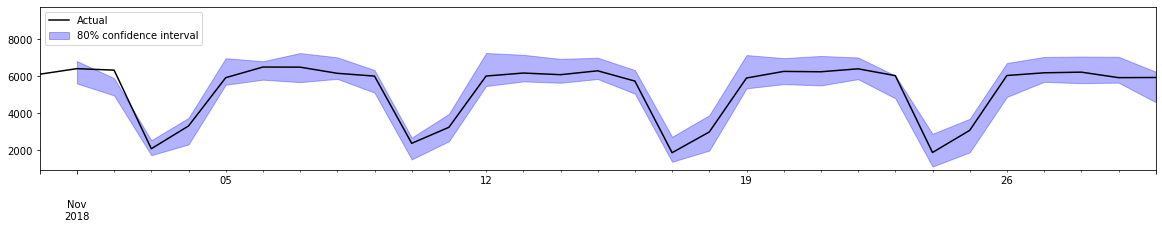

In [22]:
site_id = 33
plot_weeks = 0
confidence = 80
end_training = start_date + timedelta(days=30)
plot(
        predictor,
        target_ts=daily_power_consumption_per_site[site_id][end_training:],
        plot_weeks=plot_weeks,
        confidence=confidence
    )

## Calculate some objective statistics regarding accuracy of our model

RMSE measures the "root mean square" error. It penalises more extreme "misses" and rewards consistency.
It also has the advantage that it's magnititude is proportional to the value being predicted.
MAPE measures "Mean Absolute Percentage Error". The main reason to use MAPE is that it scores errors in
percentage terms rather than as absolutes. Hence a prediciton of 11 for a value of 10 is treated identically
to a prediction of 90 for a value of 100.

In [25]:
# Gather 30 day predictions for all timeseries
predictions= []
for i, ts in enumerate(daily_power_consumption_per_site):

    # call the end point to get the 30 day prediction
    predictions.append(predictor.predict(ts=ts[start_date+timedelta(days=30):end_training])['0.5'].sum())

usages = [ts[end_training+timedelta(days=1):end_training+timedelta(days=30)].sum() for ts in daily_power_consumption_per_site]

for p,u in zip(predictions,usages):
    print(f'Predicted {p} kwh but usage was {u} kwh,')

Predicted 40285.796508789295 kwh but usage was 36653.78 kwh,
Predicted 37696.693908691595 kwh but usage was 32167.5 kwh,
Predicted 39047.11169433591 kwh but usage was 31598.55 kwh,
Predicted 44875.386779785294 kwh but usage was 37453.53999999999 kwh,
Predicted 34747.8308105469 kwh but usage was 32476.1 kwh,
Predicted 215275.01562499965 kwh but usage was 214990.9 kwh,
Predicted 39140.859375 kwh but usage was 33968.799999999996 kwh,
Predicted 43042.02581787089 kwh but usage was 38895.90000000001 kwh,
Predicted 38323.9299316406 kwh but usage was 32477.399999999998 kwh,
Predicted 35013.31567382801 kwh but usage was 30979.4 kwh,
Predicted 42695.06732177759 kwh but usage was 34517.24 kwh,
Predicted 39433.1816406252 kwh but usage was 33820.7 kwh,
Predicted 40518.82897949219 kwh but usage was 36642.700000000004 kwh,
Predicted 38935.950988769495 kwh but usage was 32651.8 kwh,
Predicted 38599.0197753907 kwh but usage was 33723.799999999996 kwh,
Predicted 40175.6876220704 kwh but usage was 35155.

In [26]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
print(f'MAPE: {round(mape(usages, predictions),1)}%')

MAPE: 30.5%


## Remove the Endpoint (recommended)

Comment out this cell to remove the endpoint if you want the endpoint to exist after "run all"

In [28]:
# Remove the Endpoint (optional)
# Comment out this cell to remove the endpoint if you want the endpoint to exist after "run all"
sess.delete_endpoint(endpoint_name)